# 欠落変数バイアス

結果変数$Y$、処置変数$D$と、$Y,D$に影響を与える共変量（交絡因子）$X$があるとし、各変数の間には線形の関係があるとする。

処置の効果を正しく推定するためには共変量をモデルに含める必要があるため、正しいモデルは次の式の形になる（「長いモデル」ということでLとつけている）。

$$
Y = \alpha^L + \beta^L D + \gamma^L X + \varepsilon^L
$$



ここで$X$を説明変数に入れない「短いモデル」

$$
Y = \alpha^S + \beta^S D + \varepsilon^S
$$

を構築した場合、処置効果$\beta^S$はどう推定されるのだろうか。

XをDに回帰する（Xの変動をDで説明する）モデルを立ててみる。

$$
X = \alpha + \beta D + \varepsilon
$$

これを「長いモデル」に代入して整理すると、「短いモデル」との対応が見えてくる

$$
\begin{align}
Y &= \alpha^L + \beta^L D + \gamma^L (\alpha + \beta D + \varepsilon) + \varepsilon^L \\
&= \alpha^L + \gamma^L \alpha + (\beta^L + \gamma^L \beta) D  + \gamma^L \varepsilon + \varepsilon^L \\
&= \underbrace{\alpha^L + \gamma^L \alpha}_{\alpha^S}
  + \underbrace{(\beta^L + \gamma^L \beta)}_{\beta^S} D
  + \underbrace{\gamma^L \varepsilon + \varepsilon^L}_{\varepsilon^S} \\
\end{align}
$$


「短いモデル」の$\beta^S$は

$$
\beta^S = \beta^L + \gamma^L \beta
$$

であるため、正しいモデルの推定量$\beta^L$から$\gamma^L \beta$の分だけズレることがわかる。

## 生成データで実験

実際に回帰分析を行ってみる。乱数で生成する。

真の係数：α_L=3, β_L=5, γ_L=7


Y  D         X
0  12.968330  1  0.548814
1  11.926394  1  0.715189
2  11.071875  1  0.602763
3  11.376362  1  0.544883
4   5.467551  0  0.423655

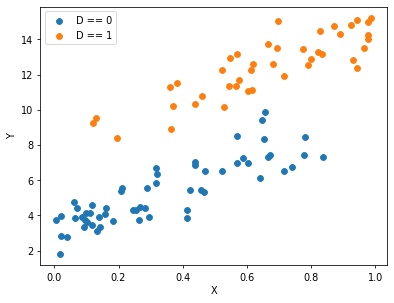

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf


# generate data
np.random.seed(0)

n = 100
X = np.random.uniform(low=0, high=1, size=n)

# XがDと独立していれば共変量でないので欠落変数バイアスは生まれない
# D = np.random.binomial(n=1, p=0.7, size=n)

# XはDとYに影響を与える共変量であるため、xと処置確率が相関するとする
D = np.array([np.random.binomial(n=1, p=x * 0.8) for x in X])

epsilon_L = np.random.normal(size=n)
alpha_L = 3
beta_L = 5
gamma_L = 7

print(f"真の係数：α_L={alpha_L}, β_L={beta_L}, γ_L={gamma_L}")
Y = alpha_L + beta_L * D + gamma_L * X + epsilon_L

# data
df = pd.DataFrame(dict(Y=Y, D=D, X=X))
display(df.head())


# plot
fig, ax = plt.subplots(dpi=70)
for d in np.unique(D):
    ax.scatter(X[D == d], Y[D == d], label=f"D == {d}")
ax.legend()
ax.set(xlabel="X", ylabel="Y")
fig.show()

このデータからそれぞれのモデルを推定すると次のようになる。

In [2]:
# long model
results = smf.ols('Y ~ D + X', data=df).fit()
alpha_L_, beta_L_, gamma_L_ = results.params
print(f"「長いモデル」の推定値：α_L={alpha_L_:.2f}, β_L={beta_L_:.2f}, γ_L={gamma_L_:.2f}")

# short model
results = smf.ols('Y ~ D', data=df).fit()
alpha_S_, beta_S_ = results.params
print(f"「短いモデル」の推定値：α_S={alpha_S_:.2f}, β_S={beta_S_:.2f}")

# X ~ D
results = smf.ols('X ~ D', data=df).fit()
alpha_, beta_ = results.params
print(f"XをDに回帰したモデルの推定値：α={alpha_:.2f}, β={beta_:.3f}")

「長いモデル」の推定値：α_L=3.16, β_L=5.04, γ_L=6.43
「短いモデル」の推定値：α_S=5.32, β_S=7.14
XをDに回帰したモデルの推定値：α=0.34, β=0.327


3つのモデルの関係性は

$$
Y = \underbrace{\alpha^L + \gamma^L \alpha}_{\alpha^S}
  + \underbrace{(\beta^L + \gamma^L \beta)}_{\beta^S} D
  + \underbrace{\gamma^L \varepsilon + \varepsilon^L}_{\varepsilon^S}
$$

だったので、推定値で同様に計算すると

In [3]:
estimated_alpha_S = (alpha_L_ + gamma_L_ * alpha_)
estimated_beta_S = (beta_L_ + gamma_L_ * beta_)
bias_beta_S = gamma_L_ * beta_

print(f"""
α_Sの推定値 = {estimated_alpha_S:.2f}
β_Sの推定値 = {estimated_beta_S:.2f}
β_Lとの差（欠落変数バイアス） = {bias_beta_S:.2f}
""")


α_Sの推定値 = 5.32
β_Sの推定値 = 7.14
β_Lとの差（欠落変数バイアス） = 2.10



となり、「短いモデル」の推定値と同じものが得られた。また、「長いモデル」と比べたときの差（バイアス）も得られた

## 誤差項との関係

$$
\varepsilon^S = \gamma^L \varepsilon + \varepsilon^L
$$

「短いモデル」の誤差項は説明変数と相関がある

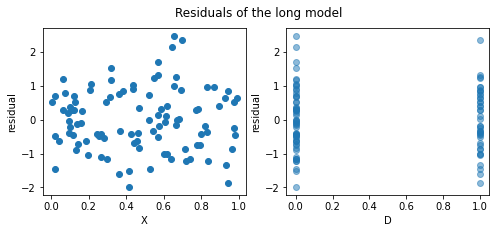

In [4]:
residuals_L = Y - smf.ols('Y ~ D + X', data=df).fit().predict(df)

fig, ax = plt.subplots(figsize=[8, 3], ncols=2, dpi=72)
ax[0].scatter(X, residuals_L)
ax[0].set(xlabel="X", ylabel="residual")

ax[1].scatter(D, residuals_L, alpha=.5)
ax[1].set(xlabel="D", ylabel="residual")

fig.suptitle("Residuals of the long model")
fig.show()

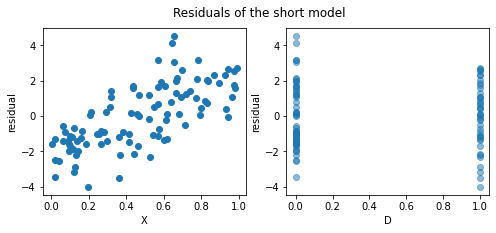

In [5]:
residuals_S = Y - smf.ols('Y ~ D', data=df).fit().predict(df)

fig, ax = plt.subplots(figsize=[8, 3], ncols=2, dpi=72)
ax[0].scatter(X, residuals_S)
ax[0].set(xlabel="X", ylabel="residual")

ax[1].scatter(D, residuals_S, alpha=.5)
ax[1].set(xlabel="D", ylabel="residual")

fig.suptitle("Residuals of the short model")
fig.show()

## 外生性

このことについては外生性・内生性といった言い方もされる。


次の単回帰モデルを考える。

$$
Y_i = \alpha + \beta X_i + \varepsilon_i, \quad i=1,2,\dots,n
$$

説明変数$X_i$と誤差項$\varepsilon_i$が相関しないとき、説明変数$X_i$が**外生性**（exogeneity）をもつと言われる。またこのような変数は**外生変数**（exogenous variable）と呼ばれる。

:::{info} 外生性

$$
E[X_i \varepsilon_i] = Cov(X_i, \varepsilon_i) = 0
$$
:::

そうでないとき、説明変数$X_i$は**内生性**（endogeneity）をもつという。

:::{info} 内生性

$$
E[X_i \varepsilon_i] = Cov(X_i, \varepsilon_i) \neq 0
$$
:::

モデルの式の両辺の期待値をとって$\alpha$について解くと$\alpha = E[Y_i] - \beta E[X_i]$であり、これを代入すると

$$
Y_i - E[Y_i] = \beta (X_i - E[X_i]) + \varepsilon_i
$$

と書き換えることができる。両辺に$X$を乗じて期待値をとると

$$
\underbrace{ E[X_i(Y_i - E[Y_i])] }_{ = E[X_i Y_i] - E[X_i] E[Y_i] \\ = Cov(X_i, Y_i) }
    = \beta \underbrace{ E[X_i (X_i - E[X_i])] }_{ = E[X_i^2] - E[X_i]^2 \\ = Var(X_i) }
    + \underbrace{ E[X_i \varepsilon_i] }_{ = Cov(X_i, \varepsilon_i) \\ = 0}
$$

移項するとOLS推定量が得られる

$$
\beta = \frac{ Cov(X_i, Y_i) }{ Var(X_i) }
$$

もし$E[X_i \varepsilon_i] = Cov(X_i, \varepsilon_i) \neq 0$であれば、

$$
\frac{ Cov(X_i, Y_i) }{ Var(X_i) } = \beta + \frac{ Cov(X_i, \varepsilon_i) }{ Var(X_i) }
$$

となり、$Cov(X_i, \varepsilon_i) \ / \ Var(X_i)$の分だけバイアスのある推定量になる

## 参考文献

- [25. 重回帰分析（脱落変数バイアス・処置後変数バイアス）](http://www.ner.takushoku-u.ac.jp/masano/class_material/waseda/keiryo/R25_reg8_OBV.html)
- 安井翔太. (2020). 効果検証入門: 正しい比較のための因果推論 計量経済学の基礎. Gijutsu hyōronsha.
- 星野匡郎, 田中久稔, & 北川梨津. (2023). R による実証分析: 回帰分析から因果分析へ. 株式会社 オーム社.


### 関連論文（積読リスト）
- [[2302.06518] SelectionBias: An R Package for Bounding Selection Bias](https://arxiv.org/abs/2302.06518)
  - RでSV boundsというバイアスの幅を推定するパッケージ
- [[2208.00552] The Effect of Omitted Variables on the Sign of Regression Coefficients](https://arxiv.org/abs/2208.00552)